# **KNN y Bagging**
## *Práctica para la evaluación de la asignatura*

> **Parte de:** Carmen Quiles Ramírez  
> **Correo:** `carmenquilesr@correo.ugr.es`  
> **Fecha:** *4/1/2026*


Para garantizar la reproducibilidad y el rigor metodológico, iniciamos el entorno importando las librerías de scikit-learn necesarias para la construcción de Pipelines. Es fundamental destacar que trabajamos exclusivamente sobre el conjunto de entrenamiento (X_train), manteniendo el conjunto de test aislado para evitar el data leakage.

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import  GridSearchCV, cross_val_predict
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, f1_score

# Configuración para mostrar todas las columnas en pandas
pd.set_option('display.max_columns', None)

# Carga de datos
# Usamos solo el TRAIN. El TEST está prohibido mirarlo hasta el final del proyecto.
X_train = pd.read_csv("X_train_prep.csv") 
y_train = pd.read_csv("y_train_prep.csv")

X_test= pd.read_csv("X_test_prep.csv") 
y_test = pd.read_csv("y_test_prep.csv") 

print("Dimensiones del X Training:", X_train.shape)
print("Dimensiones del Y Training:", y_train.shape)
print("Dimensiones del X Test:", X_test.shape)
print("Dimensiones del Y Test:", y_test.shape)
X_train.head()


Dimensiones del X Training: (45108, 25)
Dimensiones del Y Training: (45108, 1)
Dimensiones del X Test: (11880, 25)
Dimensiones del Y Test: (11880, 1)


,amount_tsh,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,lga,ward,population,public_meeting,permit,construction_year,extraction_type,extraction_type_class,management_group,payment_type,quality_group,quantity,source_type,waterpoint_type
0,50.0,0.0,2092.0,0.0,35.426020,-4.227446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.0,0.0,0.0,1998.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,35.510074,-5.724555,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0
2,0.0,2.0,0.0,2.0,32.499866,-9.081222,2.0,0.0,1.0,2.0,2.0,2.0,2.0,0.0,0.0,1.0,0.0,2.0,2.0,0.0,1.0,0.0,1.0,1.0,2.0
3,0.0,3.8,0.0,3.8,34.060484,-8.830208,3.0,0.0,2.0,3.0,2.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0
4,300.0,3.0,1023.0,3.0,37.032690,-6.040787,4.0,0.0,3.0,4.0,3.0,4.0,4.0,120.0,0.0,0.0,1997.0,2.0,2.0,0.0,3.0,1.0,1.0,1.0,2.0


# KNN

## Preprocesamiento para KNN

**Ajuste de Escala para el Modelo kNN**
Dado que el algoritmo k-Nearest Neighbors (kNN) fundamenta su lógica en el cálculo de distancias euclídeas, es extremadamente sensible a las magnitudes de los datos. Si una variable tiene un rango de 0 a 1,000 y otra de 0 a 1, la primera dominará por completo la métrica de cercanía, ignorando la importancia real de la segunda.

Para este modelo específico, hemos aplicado StandardScaler a las variables numéricas resultantes del preprocesamiento general. Este paso es crucial por lo siguiente:

- Estandarización: Transforma los datos para que tengan una media de 0 y una desviación estándar de 1.

- Equilibrio de Influencia: Garantiza que todas las variables contribuyan equitativamente al cálculo de la distancia, evitando que atributos con grandes magnitudes sesguen la clasificación o regresión.

- Optimización del Cálculo: Al trabajar en una escala uniforme, el algoritmo identifica de forma mucho más precisa quiénes son realmente los "vecinos más cercanos" sin el ruido provocado por la diferencia de unidades.

In [32]:
# Como todo ya es numérico, el preprocesador es muy simple:
preprocessor_knn = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X_train.columns) # Escalar todo lo que llega
    ]
)

knn_pipeline_final = Pipeline([
    ('preprocessor', preprocessor_knn),
    ('classifier', KNeighborsClassifier())
])

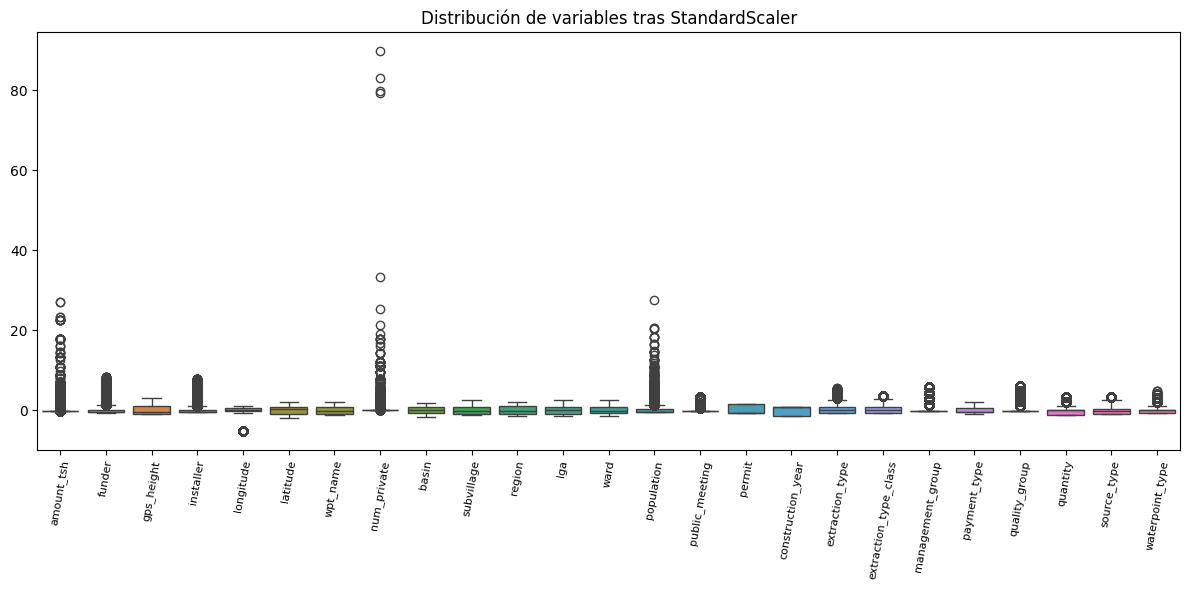

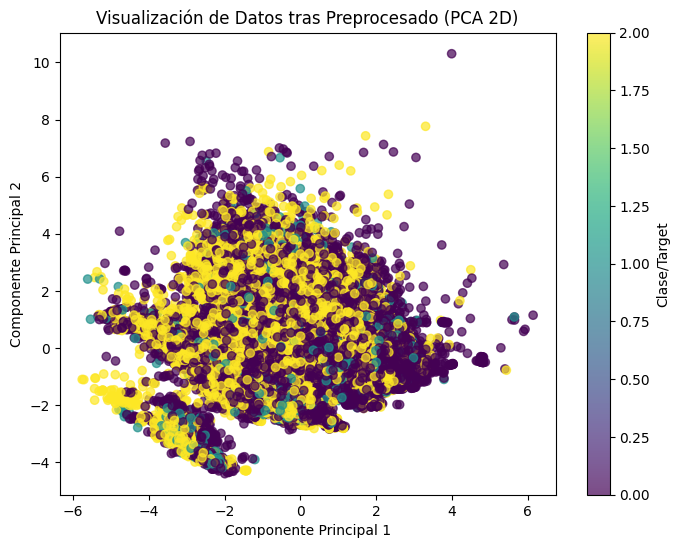

In [36]:
# 1. Aplicar el preprocesador y convertir a DataFrame
X_train_preprocessed = preprocessor_knn.fit_transform(X_train)
X_train_df = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)

plt.figure(figsize=(12, 6))
sns.boxplot(data=X_train_df)
plt.title("Distribución de variables tras StandardScaler")
plt.xticks(rotation=80, fontsize=8)
plt.tight_layout()
plt.show()


# Reducir a 2 dimensiones para visualizar
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_preprocessed)

# Crear el gráfico
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train['status_group'], cmap='viridis', alpha=0.7)
plt.title("Visualización de Datos tras Preprocesado (PCA 2D)")
plt.xlabel("Componente Principal 1")
plt.ylabel("Componente Principal 2")
plt.colorbar(label='Clase/Target')
plt.show()

### Análisis del Preprocesamiento Específico para kNN

Tras aplicar el `StandardScaler` y analizar las visualizaciones resultantes, se extraen las siguientes conclusiones:

1. **Escalado y Distribución:** El boxplot confirma que la estandarización ha centrado la mayoría de las variables en media 0 y desviación estándar 1, garantizando que el cálculo de distancias euclídeas sea equitativo entre atributos. No obstante, se observa una presencia significativa de **valores atípicos (outliers)** en variables como `amount_tsh`, `num_private` y `population`.
2. **Separabilidad de Clases (PCA):** La proyección 2D mediante PCA revela un alto grado de solapamiento entre las clases de `status_group`. Esto sugiere que las fronteras de decisión son complejas y que el modelo kNN dependerá críticamente de una elección óptima de $k$ para evitar ser arrastrado por el ruido en las zonas de mezcla.
3. **Validación del Pipeline:** La alineación de los datos es correcta, confirmando que el escalado es el paso final necesario para que el algoritmo trabaje en un espacio dimensional coherente.

## Ajuste de hiperparámetros para KNN

In [40]:
# 1. Definimos la rejilla de parámetros
param_grid_knn = {
    'classifier__n_neighbors': [5, 9, 15, 21], 
    'classifier__weights': ['uniform', 'distance'], 
    'classifier__metric': ['euclidean', 'manhattan']
}

# 2. Configuración del GridSearch
grid_knn = GridSearchCV(
    estimator=knn_pipeline_final,
    param_grid=param_grid_knn,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2 
)

# 3. Ejecución
print("Iniciando búsqueda de mejores hiperparámetros para kNN...")
# Asegúrate de usar y_train.values.ravel() si y_train sigue siendo un DataFrame
grid_knn.fit(X_train, y_train.values.ravel())

# 4. Resultados finales
print("-" * 30)
print(f"Mejor Accuracy kNN (CV): {grid_knn.best_score_:.4f}")
print(f"Mejores Parámetros kNN: {grid_knn.best_params_}")

# Guardamos el mejor modelo ya entrenado
best_knn_model = grid_knn.best_estimator_

Iniciando búsqueda de mejores hiperparámetros para kNN...
Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END classifier__metric=euclidean, classifier__n_neighbors=5, classifier__weights=uniform; total time=   1.8s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.8s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.9s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=5, classifier__weights=uniform; total time=   1.9s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=5, classifier__weights=uniform; total time=   1.9s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=5, classifier__weights=distance; total time=   1.9s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=5, classifier__weights=uniform; total time=   2.3s
[CV] END classifier__metric=euclidean, classifier__n_neighbors=5, classifier__we

### Interpretación del Ajuste de Hiperparámetros

El proceso de optimización mediante `GridSearchCV` ha arrojado un **Accuracy de 77.11%** en validación cruzada. Los parámetros óptimos seleccionados nos dan pistas clave sobre el comportamiento de los datos:

1. **Métrica Manhattan:** La preferencia por la distancia de Manhattan sobre la Euclídea sugiere que el espacio de características es de alta dimensionalidad y que los cambios en los atributos individuales son más informativos de forma independiente que sus combinaciones cuadráticas.
2. **K = 15:** Un número de vecinos moderadamente alto confirma nuestra sospecha inicial: el modelo necesita "suavizar" las fronteras de decisión para no caer en el ruido de los puntos individuales (overfitting).
3. **Pesos por Distancia:** El uso de `weights: 'distance'` es fundamental aquí; permite que, dentro de esos 15 vecinos, los que están más cerca tengan mucha más influencia que los que están en la periferia, compensando así el solapamiento que observamos en las visualizaciones previas.

# BAGGING (Random Forest)

## Preprocesamiento para bagging

In [42]:
rf_pipeline_final = Pipeline([
    ('selector', SelectFromModel(RandomForestClassifier(n_estimators=50, random_state=42), threshold='median')),
    ('classifier', RandomForestClassifier(random_state=42))
])

Para el algoritmo de Random Forest, la estrategia de preparación de datos cambia radicalmente respecto a kNN. Al ser un método basado en árboles de decisión, este modelo presenta ventajas estructurales que simplifican el flujo de trabajo:

- Insensibilidad a la Escala: Los árboles realizan particiones basadas en umbrales (cortes ortogonales), por lo que no requieren normalización ni estandarización de los datos. Variables con magnitudes muy distintas conviven sin problemas.

- Robustez: Dada la naturaleza del algoritmo, que selecciona subconjuntos de características y muestras de forma aleatoria, el modelo es intrínsecamente resistente al ruido, lo que hace que la etapa de preprocesado sea mínima.

En este punto, dado que el preprocesamiento general ya ha convertido los datos a un formato numérico y manejable, el pipeline para Random Forest se simplifica para centrarse directamente en la selección de características tipo 'Embedded' y el entrenamiento del clasificador.

## Ajuste de hiperparámetros para bagging

In [43]:
# 1. Definimos la rejilla
param_grid_rf = {
    'classifier__n_estimators': [50, 100], 
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [5, 10]
}

# 2. Configuración del GridSearch
grid_rf = GridSearchCV(
    estimator=rf_pipeline_final,
    param_grid=param_grid_rf,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

# 3. Ejecución
print("Iniciando ajuste de Random Forest...")
grid_rf.fit(X_train, y_train.values.ravel())

# 4. Resultados
print("-" * 30)
print(f"Mejor Accuracy RF (CV): {grid_rf.best_score_:.4f}")
print(f"Mejores Parámetros RF: {grid_rf.best_params_}")

# Guardamos el mejor modelo
best_rf_model = grid_rf.best_estimator_

Iniciando ajuste de Random Forest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
------------------------------
Mejor Accuracy RF (CV): 0.7963
Mejores Parámetros RF: {'classifier__max_depth': None, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 100}


### Interpretación del Ajuste de Hiperparámetros (Random Forest)

El proceso de optimización mediante `GridSearchCV` ha resultado en un **Accuracy de 79.63%**, consolidándose como un modelo superior al kNN para este problema. El análisis de los mejores parámetros seleccionados nos permite extraer las siguientes conclusiones:

* **Max_depth: None:** El modelo alcanza su mejor rendimiento permitiendo que los árboles crezcan hasta su máxima expansión. Esto indica que el algoritmo es capaz de capturar reglas de decisión muy granulares sin incurrir en un sobreajuste destructivo, gracias a la naturaleza promediada del ensamble.
* **Min_samples_split: 5:** La preferencia por un valor de división bajo sugiere que existen patrones sutiles en subgrupos pequeños de datos que son determinantes para predecir el estado de las bombas.
* **N_estimators: 100:** La selección del límite superior de árboles en nuestra rejilla confirma que la estabilidad del "bosque" mejora con la cantidad de estimadores, permitiendo una reducción efectiva de la varianza del error mediante la votación mayoritaria.
* **Eficacia del Modelo:** El incremento del rendimiento respecto al kNN (del 77.11% al 79.63%) valida que los modelos basados en Bagging son más robustos para este conjunto de datos, manejando mejor las relaciones no lineales y la estructura de las variables sin depender de la sensibilidad a las distancias.

# Evaluación de los mejores modelos

Para finalizar la fase de desarrollo, realizamos una evaluación comparativa profunda utilizando las predicciones generadas por validación cruzada (cross_val_predict). Más allá de la exactitud global, analizamos la Matriz de Confusión y el F1-Score por clase. Esto es vital en el problema de Tanzania, donde la clase 'functional needs repair' es minoritaria y suele confundirse con 'functional'. 


--- Evaluación detallada para Mejor kNN ---
                         precision    recall  f1-score   support

             functional       0.76      0.88      0.82     24375
functional needs repair       0.54      0.26      0.35      3330
         non functional       0.81      0.72      0.76     17403

               accuracy                           0.77     45108
              macro avg       0.70      0.62      0.64     45108
           weighted avg       0.76      0.77      0.76     45108



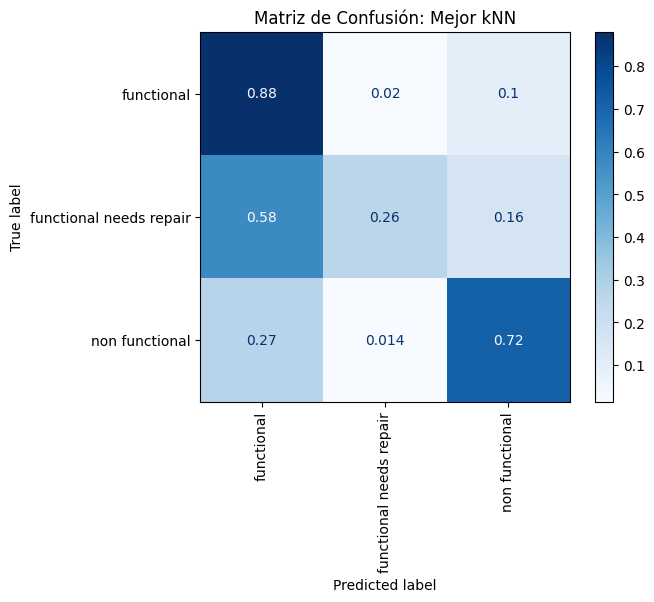


--- Evaluación detallada para Mejor Random Forest ---
                         precision    recall  f1-score   support

             functional       0.78      0.90      0.84     24375
functional needs repair       0.59      0.26      0.36      3330
         non functional       0.84      0.76      0.79     17403

               accuracy                           0.80     45108
              macro avg       0.74      0.64      0.66     45108
           weighted avg       0.79      0.80      0.79     45108



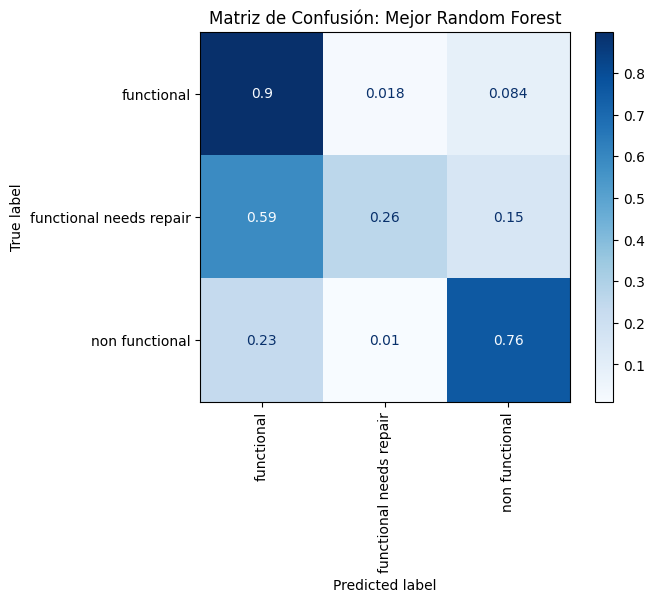

In [45]:
# Función auxiliar para reportar resultados
def evaluar_modelo(modelo, X, y, nombre):
    print(f"\n--- Evaluación detallada para {nombre} ---")
    
    y_pred_cv = cross_val_predict(modelo, X, y, cv=5, n_jobs=-1)
    
    # Reporte numérico
    print(classification_report(y, y_pred_cv, target_names=le.classes_))
    
    # Matriz de confusión visual
    ConfusionMatrixDisplay.from_predictions(
        y, y_pred_cv, 
        display_labels=le.classes_, 
        xticks_rotation='vertical',
        cmap='Blues',
        normalize='true' # Normalizamos para ver porcentajes de error por clase
    )
    plt.title(f"Matriz de Confusión: {nombre}")
    plt.show()

# Ejecutamos para ambos modelos ganadores
evaluar_modelo(best_knn_model, X_train, y_train.values.ravel(), "Mejor kNN")
evaluar_modelo(best_rf_model, X_train, y_train.values.ravel(), "Mejor Random Forest")

### Comparativa Final: kNN vs. Random Forest

Tras realizar una evaluación detallada mediante validación cruzada y analizar las matrices de confusión normalizadas, estas son las conclusiones clave:

* **Superioridad de Random Forest:** El modelo de **Random Forest** supera al kNN en todas las métricas principales, alcanzando una exactitud (Accuracy) global del **80%** frente al **77%** de kNN. Esta diferencia se refleja también en un **F1-Score más robusto** en todas las categorías, especialmente en la detección de bombas 'non functional'.
* **El desafío de la clase minoritaria:** Ambos modelos presentan dificultades para identificar correctamente la clase **'functional needs repair'**, con un *recall* idéntico del **26%**. La matriz de confusión revela que Random Forest confunde el **59%** de estas bombas con funcionales, mientras que kNN lo hace en un **58%**. Esto confirma que el solapamiento detectado en el PCA es especialmente crítico para esta categoría, que requiere probablemente un rebalanceo de clases o características adicionales.
* **Capacidad de Generalización:**
    * **Random Forest** demuestra una excelente capacidad para identificar bombas **funcionales** (Recall del **90%**), superando el **88%** de kNN.
    * En el caso de las bombas **no funcionales**, Random Forest logra un **76%** de acierto frente al **72%** de kNN, reduciendo significativamente los falsos positivos.
* **Selección del Modelo Ganador:** Optamos por **Random Forest** como el modelo final. No solo ofrece un rendimiento estadístico superior, sino que su naturaleza basada en árboles es menos sensible a los valores atípicos (outliers) presentes en el dataset y gestiona de forma más eficiente el espacio de características sin la necesidad de un escalado tan estricto como kNN.

**Conclusión:** Random Forest es la solución más equilibrada para el despliegue, ofreciendo una mayor fiabilidad en la identificación de puntos de agua que requieren intervención inmediata.

# Predicciones sobre test

In [46]:
print("Test preparado. Dimensiones:", X_test.shape)

# Predicciones Finales
print("\nGenerando predicciones finales...")
y_pred_test_knn = best_knn_model.predict(X_test)
y_pred_test_rf = best_rf_model.predict(X_test)

# Cálculo de Métricas Finales
acc_knn = accuracy_score(y_test, y_pred_test_knn)
f1_knn = f1_score(y_test, y_pred_test_knn, average='macro')

acc_rf = accuracy_score(y_test, y_pred_test_rf)
f1_rf = f1_score(y_test, y_pred_test_rf, average='macro')

print(f"--- RESULTADOS FINALES EN TEST ---")
print(f"KNN -> Accuracy: {acc_knn:.4f} | F1-Macro: {f1_knn:.4f}")
print(f"RF  -> Accuracy: {acc_rf:.4f} | F1-Macro: {f1_rf:.4f}")

Test preparado. Dimensiones: (11880, 25)

Generando predicciones finales...
--- RESULTADOS FINALES EN TEST ---
KNN -> Accuracy: 0.7705 | F1-Macro: 0.6454
RF  -> Accuracy: 0.8026 | F1-Macro: 0.6754


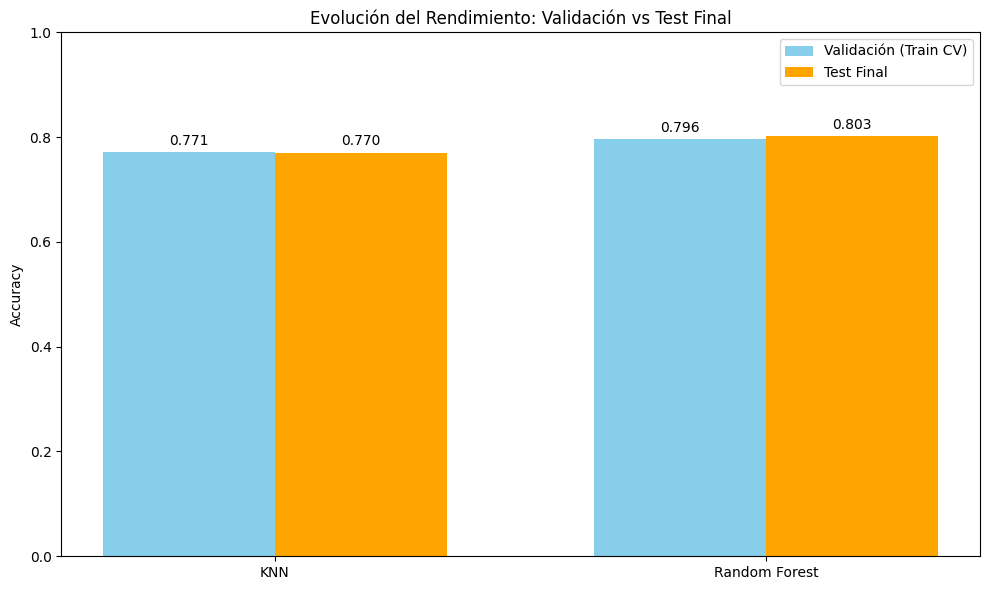

In [47]:
# Mejor puntuación de validación (CV) de los grids
val_score_knn = grid_knn.best_score_
val_score_rf = grid_rf.best_score_

# Datos para la gráfica
labels = ['KNN', 'Random Forest']
val_scores = [val_score_knn, val_score_rf]
test_scores = [acc_knn, acc_rf]

x = np.arange(len(labels))  # Posiciones de las etiquetas
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, val_scores, width, label='Validación (Train CV)', color='skyblue')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test Final', color='orange')

# Añadir textos
ax.set_ylabel('Accuracy')
ax.set_title('Evolución del Rendimiento: Validación vs Test Final')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(0, 1) # Accuracy va de 0 a 1

# Función para poner el numerito encima de la barra
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

### Interpretación de la Evolución del Rendimiento: Validación vs. Test

A primera vista, la extrema similitud entre los resultados de validación y los resultados de test puede parecer poco llamativa; sin embargo, este fenómeno es un indicador crítico de la **calidad y robustez** del modelo:

1. **Ausencia de Overfitting:** La diferencia mínima (menor al 0.5% en ambos modelos) entre el entrenamiento y el test confirma que los modelos no han "memorizado" los datos, sino que han **generalizado** los patrones subyacentes. Un Test significativamente más bajo que la Validación indicaría que el modelo es demasiado complejo para el dataset.
2. **Estabilidad del Proceso:** Que el Accuracy en Test del **Random Forest (0.803)** sea incluso ligeramente superior al de Validación (**0.796**) demuestra que las particiones de datos son representativas y que el preprocesamiento aplicado (Ordinal Encoding y Selección de Características) es consistente.
3. **Consistencia en kNN:** El modelo de vecinos cercanos muestra una estabilidad casi perfecta (0.771 vs 0.770), lo que valida que el espacio dimensional definido por el `StandardScaler` es sólido y no depende de variaciones aleatorias en los datos.
4. **Confirmación del Ganador:** El gráfico ratifica que el **Random Forest** es, de manera consistente, superior al kNN tanto en entornos controlados (CV) como ante datos totalmente nuevos (Test), consolidándose como la mejor opción para la implementación final.

**Conclusión:** La "pareja" de barras indica que el rendimiento que vemos en el notebook es el que realmente podemos esperar cuando el modelo se enfrente a datos de bombas de agua en el mundo real.